github link: https://github.com/lsiver/ml1project

## Project Description
I will attempt to model the presence of heart disease (target) based on many features such as cholesterol, resting heart rate, maximum achievable heartrate, and many other features. This is a supervised learning classification problem and many different methods are used such as: Logistic Regression, Ridge Classification, KNN, Ensemble Random Forest, and Support Vector Machine. Many of the methods will make use of a "Grid Search" to optimize the tuning parameter values that are applicable to each method in order to produce the best accuracy.
The goal is to be able to find a method that will predict heart disease with a high accuracy and to determine which factors are key. Preferably, determining a model with only a few inputs can provide early diagnosis of heart disease for someone or at the very least provide leading indicators that someone could develop heart disease.

## Data Source
The data was taken from the UC Irvine Machine Learning Repository. This data is anonymous health data taken from patients from different clinics. For the purposes of this project, only data taken from the Cleveland clinic is used. Data from Switzerland, Hungary, and Long Beach are also included in the repository.

The data is about ~660kb in size. There are 303 rows (entries) and 14 columns (13 features, 1 target-feature).
The features are age, sex, chest pain (type), resting blood pressure, cholesterol, fasting blood sugar, resting ecg, maximum heart rate, exercise induced angina, ST depression induced by exercise, exercise ST segment slope, number of major blood vessels colored by fluoroscopy, and thallium heart scan. The target feature is the presence of heart disease.  5 of these features are numeric, and the latter 9 are categorical features.

University of California, Irvine. (n.d.). *Heart disease [Data set].* UCI Machine Learning Repository. Retrieved March 22, 2025, from https://archive.ics.uci.edu/dataset/45/heart+disease

In [48]:
import copy
import math
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from ucimlrepo import fetch_ucirepo

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from prettytable import PrettyTable

# Set display and plot options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set()
%matplotlib inline


In [49]:
# fetch dataset 
heart_disease_full = fetch_ucirepo(id=45)  
dfd = heart_disease_full.data.features 
dfd['target'] = heart_disease_full.data.targets 

## Data Cleaning
This dataset requires minimal preprocessing. Since the purpose of this project is to determine the presence of heart disease, I adjusted the heart disease values. Initially it is a categorical variable which describes the severity of heart disease ranging from 0 to 4 as whole numbers. I have adjusted the values to be any value >= 1 to be set to 1. Classification accuracy of predicting the presence heart disease as yes(1)/no(0) will be more accurate than attempting to predict the severity and the presence of heart disease (1/2/3/4). 

### Outliers
I also checked for extreme outliers. Each feature seemed to have reasonable values when compared to the mean except for cholesterol where there was a very high value for one entry. This entry was removed. It is likely this is a valid entry but being a far outlier could affect any regressions negatively.

### Null Values/Feature Imputation
There were 4 null values in the ca feature and 2 in the thal feature. Feature imputation was used here for each of these missing values. The null values were replaced by its respective feature's mode value. This saves 6 entries out of 303 entries from being dropped from the dataset. 

### Other Data Issues
Some of the classification methods work much better when the numerical features are normalized before using them as inputs. When the raw test and training data is split 20/80, I also maintain a set that has the numerical features normalized.
Methods which work better when using normalized inputs: Logistic Regression, Ridge Classifier, K-Nearest Neighbors, and Support Vector Machine (SVM). The method used in this project which did not used normalized inputs is the Random Forest method. Other than this normalization issue, I cannot foresee any issue from a data perspective.

Another data issue is the small number of entries (300) compared to input features (13). This could cause issues with overfitting due to some features not having enough variation in the data for a model to determine its true significance. It's possible that some features will be regressed against noise instead of real variation. This project will use multiple models in an attempt to lessen the problem of overfitting since some models are less prone to overfitting than others.

### Visualizations
Histograms for the numerical values are shown below as well as bar-charts for the categorical values. The numerical values show a reasonable normal distribution. The categorical values are mostly a balanced distribution.

Some of the categorical features show an imbalance. The implications of this is that the imbalance *could* affect the model bias. Some of the learning algorithms could struggle to learn from imbalanced features which will result in biased predictions or poor generalization for the underrepresented groups. Generally learning algorithms are more sensitive to the target feature being imbalanced and the target feature in this data is well-balanced so this is not a major concern.

In [50]:
#Change any target values >=1 to 1
#Enough to identify heart disease, not the severity
dfd.loc[dfd['target'] >= 1, 'target'] = 1

In [51]:
null_NaN = dfd.isnull().sum()
print(null_NaN)
#4 Null values in CA, 2 in thal -> use the mode for each

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


In [52]:
mode = dfd['ca'].mode()[0] 
dfd['ca'] = dfd['ca'].fillna(mode)
mode = dfd['thal'].mode()[0]
dfd['thal'] = dfd['thal'].fillna(mode)

In [53]:
#Drop any entries where it is null
#dfd = dfd.dropna(subset=['ca','thal'])
#no longer used since decided to use mode

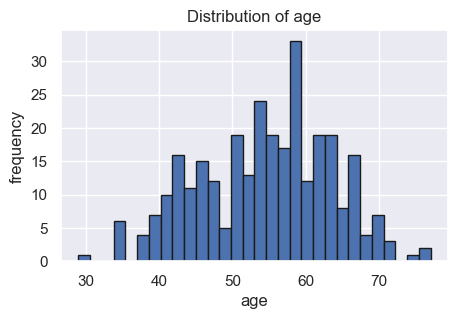

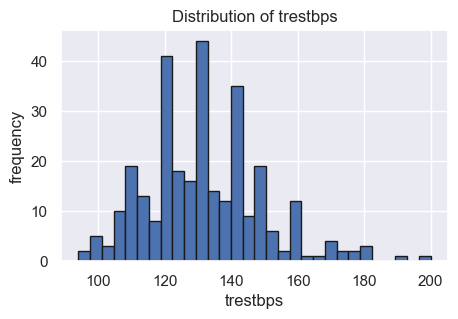

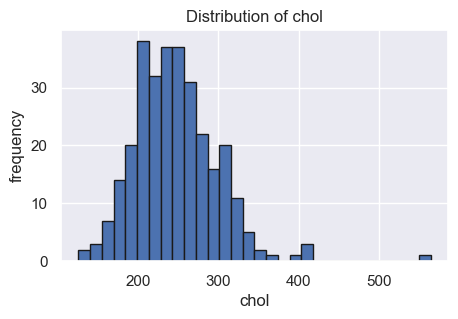

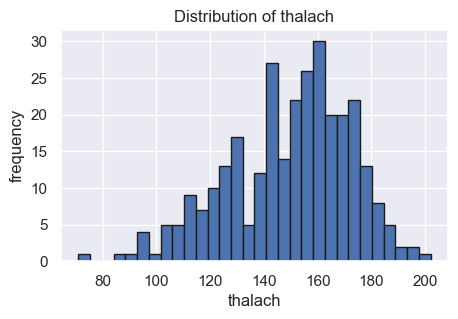

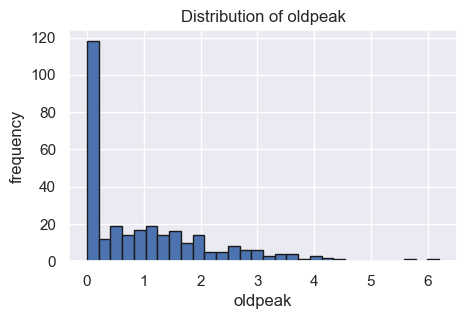

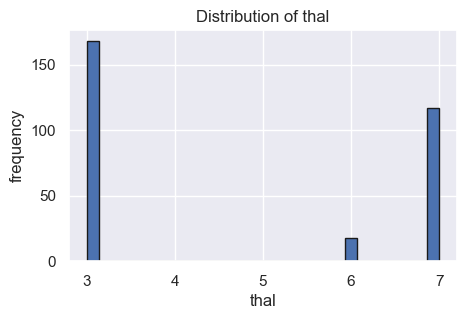

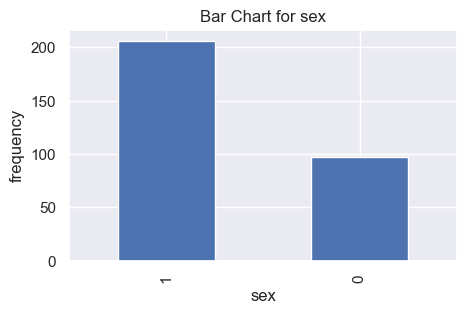

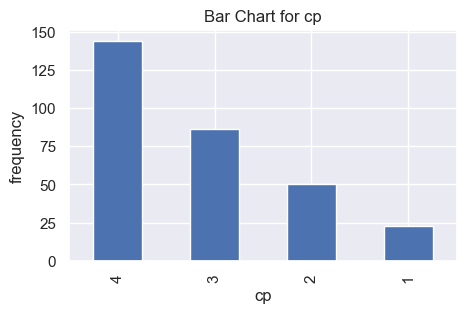

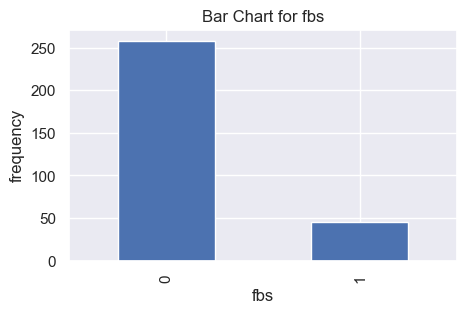

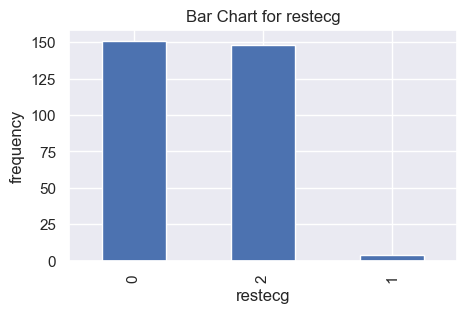

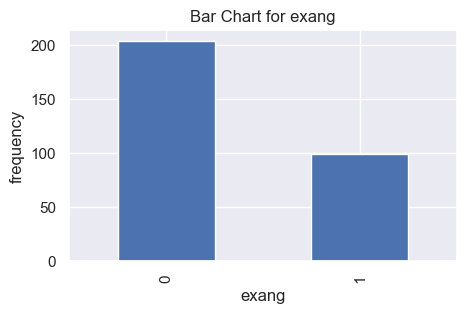

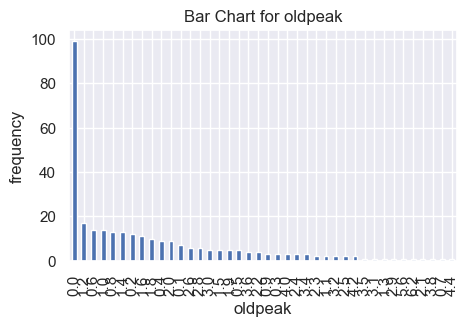

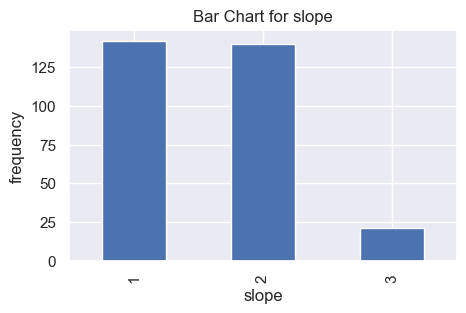

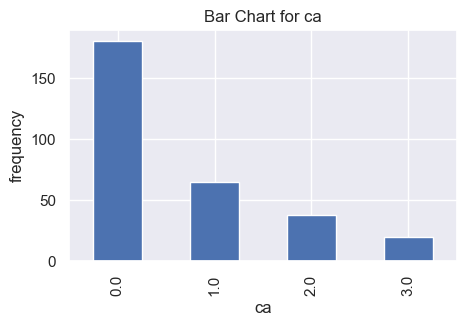

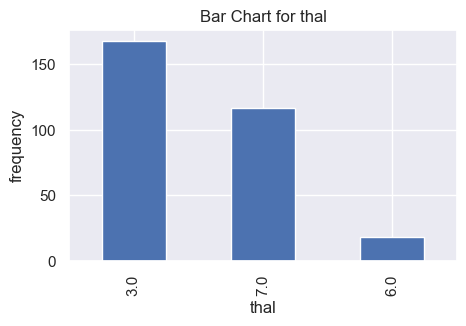

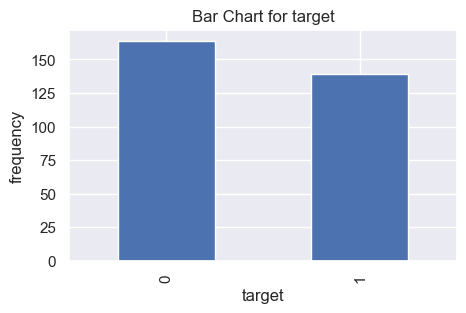

In [54]:
nums = ['age','trestbps','chol','thalach','oldpeak','thal']
bins = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
for column in nums:
    plt.figure(figsize=(5,3))
    plt.hist(dfd[column].dropna(),bins=30,edgecolor='k')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('frequency')
    #plt.savefig(f'{column}_hist.png')
for column in bins:
    plt.figure(figsize=(5,3))
    dfd[column].value_counts().plot(kind="bar")
    plt.title(f'Bar Chart for {column}')
    plt.xlabel(column)
    plt.ylabel('frequency')    
    #plt.savefig(f'{column}_bar.png')

### Statistical Distribution Values
In addition to the visualizations above, the statistical values are presented below. These were used in deciding if any specific entries are necessary to be dropped from the dataset. Max, Min, Mean, Std Deviation, Mode, and Median are calculated for each feature. As discussed before, **chol** had one large outlier (564) which was dropped. 

In [55]:
#No significant outliers found except for a ~564 cholesterol value, going to drop that entry
dfd = dfd[dfd["chol"] != 564]
table = PrettyTable()
table.field_names = ["Column", "Max", "Min", "Mean", "Std Dev", "Mode", "Median"]
for col in dfd.columns:
    table.add_row([
        col, 
        dfd[col].max(), 
        dfd[col].min(), 
        f'{dfd[col].mean():.02f}', 
        f'{dfd[col].std():.02f}', 
        f'{dfd[col].mode()[0]:.02f}', 
        f'{dfd[col].median():.02f}'
    ])
display(table)
#print(table)

Column,Max,Min,Mean,Std Dev,Mode,Median
age,77,29,54.40,9.02,58.00,55.50
sex,1,0,0.68,0.47,1.00,1.00
cp,4,1,3.16,0.96,4.00,3.00
trestbps,200,94,131.75,17.60,120.00,130.00
chol,417,126,245.64,48.52,197.00,240.50
fbs,1,0,0.15,0.36,0.00,0.00
restecg,2,0,0.99,0.99,0.00,0.50
thalach,202,71,149.57,22.91,162.00,152.50
exang,1,0,0.33,0.47,0.00,0.00
oldpeak,6.2,0.0,1.04,1.16,0.00,0.80


## Correlation, Colinearity
The correlation of each feature against the target feature is shown below. It is ordered by absolute magnitude (and importance). Positive values show a positive correlation and negative values a negative correlation. This calculation assumes a linear-correlation. Most of the features show a decent correlation to the target-feature except for fbs (fasting blood sugar) where the correlation is 0.024031. It's likely that this feature will have very little importance in the models.

In [56]:
corr_matrix = dfd.corr()
sorted_corr = corr_matrix['target'].loc[corr_matrix['target'].abs().sort_values(ascending=False).index]
print(sorted_corr)

target      1.000000
thal        0.527594
ca          0.458893
exang       0.430721
oldpeak     0.426748
thalach    -0.416507
cp          0.414543
slope       0.341910
sex         0.273721
age         0.228417
restecg     0.172840
trestbps    0.148360
chol        0.111190
fbs         0.024031
Name: target, dtype: float64


### Correlation Between Features
The full correlation matrix is shown below. There does not appear to be *major* concerns in the data.

**Oldpeak/Slope**: Strong correlation between these two features (~0.6) suggests they could be expressing similar underlying information. If they are colinear, then this will cause issues in models that assume that each feature has independence.

**Sex/Thal**: A moderate correlation shown between these two features. An irregular thallium heart scan could present itself differently across genders which might require a stratified analysis in the future.

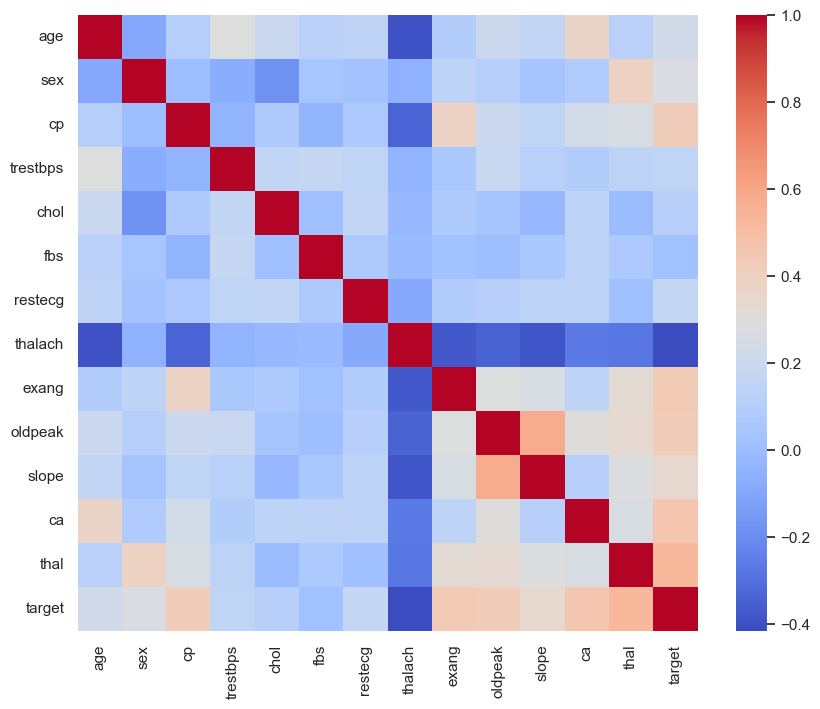

In [57]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

### Feature Collinearity Analysis
The variance influence factor (VIF) is calculated below for each feature. The VIF is a measure to quantify multicollinearity/correlation between independent variables and assesses how much of the variance of a regression coefficient is inflated due to this correlation. VIF values greater than 5 indicate strong collinearity which must be addressed, typically by dropping the least effective of the collinear variables.

None of the features show strong collinearity.

In [58]:
preds = dfd.drop('target',axis=1)
x = sm.add_constant(preds)
vif_dfd = pd.DataFrame()
vif_dfd["feature"] = x.columns
vif_dfd["VIF"] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
table = PrettyTable()
table.field_names = ["Feature", "VIF"]
for index, row in vif_dfd.iterrows():
    table.add_row([row["feature"], f"{row['VIF']:.2f}"])
display(table)
#No significant colinearity issues. VIF are all low.

Feature,VIF
const,252.78
age,1.49
sex,1.29
cp,1.32
trestbps,1.22
chol,1.14
fbs,1.07
restecg,1.09
thalach,1.63
exang,1.39


In [59]:
#X_train, X_test, y_train, y_test = train_test_split(dfd.drop(columns=['target']), dfd['target'], test_size=0.2, random_state=42)

In [60]:
#Will need to normalize the continuous features
#print(X_train)
cont_col = ['age','trestbps','chol','thalach','oldpeak','thal']
bin_col = ['sex','cp','fbs','restecg','exang','slope','ca']
X = dfd.drop(columns=['target'])
Y = dfd['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train[cont_col]),columns=cont_col,index=X_train.index)
X_test_s = pd.DataFrame(scaler.fit_transform(X_test[cont_col]),columns=cont_col,index=X_test.index)
Xs_train = pd.concat([X_train_s,X_train[bin_col]],axis=1)
Xs_test = pd.concat([X_test_s,X_test[bin_col]],axis=1)
scaled_X = pd.DataFrame(scaler.fit_transform(dfd.drop(columns=['target'])[cont_col]),columns=cont_col)
#####################################


### Logistic Regression Model
Modelling the input features against the target feature using a Logistic Regression. A gridsearch is used in order to optimize the Logistic Regression's tuning parameters: regularization strength C, penalty (L1/L2), solver (liblinear or saga) and class weight (none, balanced). The gridsearch uses a 5 fold cross-validation. Normalized inputs are used for the Logistic Regression.

In [61]:
#dictionary to store results for later presentation
allresdict = {"LR":{},"RC":{},"KNN":{},"RF":{},"SVM":{}}
pruneresdict = {"LR":{},"RC":{},"KNN":{},"RF":{},"SVM":{}}

In [62]:
grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'], 
    'class_weight': [None, 'balanced']
}
LR = LogisticRegression(max_iter=10000)
gridsearch = GridSearchCV(LR,grid,cv=5,scoring='accuracy')
gridsearch.fit(Xs_train,y_train)
#print("Best Parameters: ",gridsearch.best_params_)
#print("Best Score: ",gridsearch.best_score_)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [63]:
C_val = gridsearch.best_params_['C']
classw = gridsearch.best_params_['class_weight']
penaltyv = gridsearch.best_params_['penalty']
solverv = gridsearch.best_params_['solver']

In [64]:
LR = LogisticRegression(max_iter=10000,C=C_val,class_weight=classw,penalty=penaltyv,solver=solverv).fit(Xs_train,y_train)
y_pred = LR.predict(Xs_test)
best_accuracy = accuracy_score(y_test,y_pred)
print(f'Best Accuracy Attained: {best_accuracy:0.03f}')
##########
allresdict["LR"]["acc"] ="{:.2f}".format(best_accuracy)
##########
ypp = LR.predict_proba(Xs_test)
y_pred = LR.predict(Xs_test)
fpr, tpr, th = roc_curve(y_test,ypp[:,1])
auc = roc_auc_score(y_test,ypp[:,1])
allresdict["LR"]["auc"] = "{:.2f}".format(auc)
allresdict["LR"]["recall"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"])
allresdict["LR"]["F1"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"])

Best Accuracy Attained: 0.852


### Pruning Input Features *(Logistic Regression)*
The statsmodels logistic regression summary *(below)* implies that age, trestbps, thalach, oldpeak, fbs, and restecg may not be significant since each of their p-values are > 0.05. These variables will be removed and the logistic regression will be fitted against just features that remain.

The accuracy attained after this pruning is performed is: 0.852.

Additionally, a "greedy" pruning method was attempted as well. Starting from the full feature list, each feature is checked to see if its removal would result in an accuracy that is at most 0.01 worse than without it. If the accuracy is not significantly changed by its removal, it is removed. The accuracy with this technique is 0.84 and only required 4 features.

In [65]:
X_sm = sm.add_constant(Xs_train)
m_sm = sm.Logit(y_train, X_sm)
result = m_sm.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.322396
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  241
Model:                          Logit   Df Residuals:                      227
Method:                           MLE   Df Model:                           13
Date:                Wed, 02 Apr 2025   Pseudo R-squ.:                  0.5318
Time:                        15:35:19   Log-Likelihood:                -77.698
converged:                       True   LL-Null:                       -165.95
Covariance Type:            nonrobust   LLR p-value:                 8.762e-31
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6326      1.232     -4.570      0.000      -8.048      -3.217
age            0.1223      0.

In [66]:
X_LR_Prune_train = Xs_train.drop(['age','trestbps','thalach','oldpeak','fbs','restecg'], axis=1)
X_LR_Prune_test = Xs_test.drop(['age','trestbps','thalach','oldpeak','fbs','restecg'], axis=1)
#X_LR_Prune_train = Xs_train.drop(['age','trestbps','thalach','oldpeak','fbs','restecg','chol','sex'], axis=1)
#_LR_Prune_test = Xs_test.drop(['age','trestbps','thalach','oldpeak','fbs','restecg','chol','sex'], axis=1)
#print(X_LR_Prune_train)

In [67]:
LR = LogisticRegression(max_iter=10000,C=C_val,class_weight=classw,penalty=penaltyv,solver=solverv).fit(X_LR_Prune_train,y_train)
y_pred = LR.predict(X_LR_Prune_test)
best_accuracy = accuracy_score(y_test,y_pred)
print(f'Accuracy after manually pruning input features: {best_accuracy:0.03f}')
#print(X_LR_Prune_train)
##########
pruneresdict["LR"]["acc"] = "{:.2f}".format(best_accuracy)
##########
#print(X_LR_Prune_train.columns)

Accuracy after manually pruning input features: 0.852


In [68]:
LRLoop = LogisticRegression(max_iter=10000, C=C_val, class_weight=classw, penalty=penaltyv, solver=solverv)
best_features = list(Xs_train.columns)
best_acc = np.mean(cross_val_score(LRLoop, Xs_train[best_features], y_train, cv=5, scoring='accuracy'))
improvement = True
while improvement:
    improvement = False
    for feat in best_features.copy():
        candidate_features = best_features.copy()
        candidate_features.remove(feat)
        candidate_acc = np.mean(cross_val_score(LRLoop, Xs_train[candidate_features], y_train, cv=5, scoring='accuracy'))
        if candidate_acc >= best_acc - .01:
            best_features = candidate_features
            best_acc = candidate_acc
            improvement = True
            break
print(f'Greedy Pruning Training accuracy: {best_acc:.03f}')
print("Features left after greedy pruning algo: ",best_features)
LRLoop.fit(Xs_train[best_features], y_train)
y_pred_final = LRLoop.predict(Xs_test[best_features])
test_acc = accuracy_score(y_test, y_pred_final)
print(f'Greedy Pruning Test Accuracy: {test_acc:.03f}')

Greedy Pruning Training accuracy: 0.838
Features left after greedy pruning algo:  ['thal', 'exang', 'slope', 'ca']
Greedy Pruning Test Accuracy: 0.803


### Conclusion *(Logistic Regression)*
The target feature can be adequately predicted with chol, thal, sex, cp, exang, slope, and ca. The accuracy of the model after pruning is equal to the model before pruning.

**AUC & ROC:** The ROC Curve and AUC is shown below. This model has an AUC of 0.875 which is very strong predictive preformance.

**Summary**: The classification report for the logistic regression is also shown below. Note the accuracy of 0.85. The precision, recall, and F1-scores for correctly categorizing heart disease (0/1) is also in the mid 0.80's, which is good.

Logistic Regression Summary:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85        31
           1       0.84      0.87      0.85        30

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



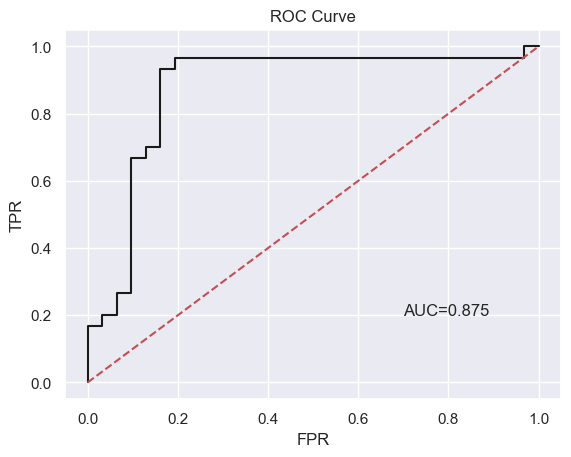

In [69]:
ypp_lr = LR.predict_proba(X_LR_Prune_test)
y_pred = LR.predict(X_LR_Prune_test)
fpr_lr, tpr_lr, th = roc_curve(y_test,ypp_lr[:,1])
auc_lr = roc_auc_score(y_test,ypp_lr[:,1])
plt.plot(fpr_lr,tpr_lr,'k-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'r--')
plt.title('ROC Curve');
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.text(0.7,0.2,'AUC='+"{:.3f}".format(auc_lr));
######################
print("Logistic Regression Summary:\n", classification_report(y_test, y_pred))
#############
pruneresdict["LR"]["auc"] = "{:.2f}".format(auc_lr)
pruneresdict["LR"]["recall"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"])
pruneresdict["LR"]["F1"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"])
#############

### Ridge Classifier 
Modelling the input features against the target feature using a Ridge Classifier. A gridsearch is used in order to optimize the Ridge Classifier's tuning parameters: alpha and solver(auto, cholesky, lsqr, sag). The gridsearch uses a 5 fold cross-validation. Normalized inputs are used for the Ridge Classifier.

In [70]:
params={
    'alpha':[0.01,0.1,1.0,10.0,100.0],
    'solver':['auto','cholesky','lsqr','sag']}
grid=GridSearchCV(RidgeClassifier(),params,cv=5,scoring='accuracy')
grid.fit(Xs_train,y_train)

GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'solver': ['auto', 'cholesky', 'lsqr', 'sag']},
             scoring='accuracy')

In [71]:
#print(grid.best_params_)
alpha = grid.best_params_['alpha']
solver = grid.best_params_['solver']

In [72]:
clf = RidgeClassifier(solver=solver,alpha=alpha)
clf.fit(Xs_train,y_train)
y_pred = clf.predict(Xs_test)
#print(classification_report(y_test,y_pred))
best_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy with all inputs used")
print(f'Best Accuracy Attained: {best_accuracy:0.03f}')
#############
allresdict["RC"]["acc"] = "{:.2f}".format(best_accuracy)
#############
allresdict["RC"]["recall"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"])
allresdict["RC"]["F1"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"])

Accuracy with all inputs used
Best Accuracy Attained: 0.869


### Pruning Input Features *(Ridge Classifier)*
The accuracy obtained before any feature pruning is: 0.869.
After pruning some features similarly to the Logistic Regression model prior (Ridge Classifier is similar to Logistic Regression), the accuracy is still 0.869.

Additionally, a "greedy" pruning method was attempted as well. Starting from the full feature list, each feature is checked to see if its removal would result in an accuracy that is at most 0.01 worse than without it. If the accuracy is not significantly changed by its removal, it is removed. The accuracy with this technique is 0.84 and only required 5 features.

In [73]:
clf = RidgeClassifier(solver=solver,alpha=alpha).fit(X_LR_Prune_train,y_train)
y_pred = clf.predict(X_LR_Prune_test)
best_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy after input pruning")
print(f'Best Accuracy Attained: {best_accuracy:0.03f}')
#print(X_LR_Prune_train)
pruneresdict["RC"]["acc"] = "{:.2f}".format(best_accuracy)
#############
pruneresdict["RC"]["recall"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"])
pruneresdict["RC"]["F1"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"])

Accuracy after input pruning
Best Accuracy Attained: 0.869


In [74]:
RClas = RidgeClassifier(solver=solver,alpha=alpha)
best_features = list(Xs_train.columns)
best_acc = np.mean(cross_val_score(RClas, Xs_train[best_features], y_train, cv=5, scoring='accuracy'))
improvement = True
while improvement:
    improvement = False
    for feat in best_features.copy():
        candidate_features = best_features.copy()
        candidate_features.remove(feat)
        candidate_acc = np.mean(cross_val_score(RClas, Xs_train[candidate_features], y_train, cv=5, scoring='accuracy'))
        if candidate_acc >= best_acc - .005:
            best_features = candidate_features
            best_acc = candidate_acc
            improvement = True
            break
print(f'Greedy Pruning Training accuracy: {best_acc:.03f}')
print(best_features)
RClas.fit(Xs_train[best_features], y_train)
y_pred_final = RClas.predict(Xs_test[best_features])
test_acc = accuracy_score(y_test, y_pred_final)
print(f'Greedy Pruning Test Accuracy: {test_acc:.03f}')

Greedy Pruning Training accuracy: 0.843
['thalach', 'thal', 'exang', 'slope', 'ca']
Greedy Pruning Test Accuracy: 0.803


### Conclusion *(Ridge Classifier)*
The target feature can be adequately predicted with chol, thal, sex, cp, exang, slope, and ca. The accuracy of the model after pruning (including 7 input features) is equal to the model before pruning. Pruning even further and using only 5 features, the accuracy is 0.84.

**Summary**: The classification report for the ridge classifier is shown below. Note the accuracy of 0.87. The precision, recall, and F1-scores for correctly categorizing heart disease (0/1) is also in the mid 0.80's, which is good.

In [75]:
print("Logistic Regression Summary:\n", classification_report(y_test, y_pred))

Logistic Regression Summary:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.84      0.90      0.87        30

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



### KNN Method
Modelling the input features against the target feature using a k-Nearest Neighbor approach. The value of "k" in the k-nearest neighbors is optimized by running through all of the values of k from 1 - 30 and selecting the k that produces the model with the highest accuracy. Normalized inputs are used for the KNN modelling.

k neighbors used 7 with an accuracy of 0.836


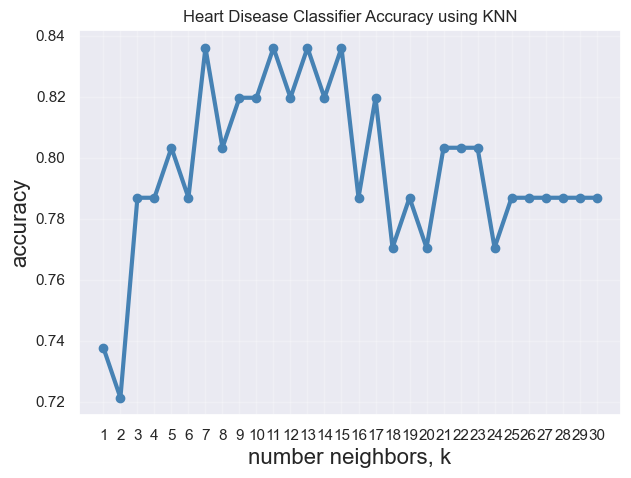

In [76]:
best_k = 0
old_score = 0
scores = []
wacc = []
allks = range(1,31)
for k in allks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xs_train, y_train)
    score = knn.score(Xs_test, y_test)
    scores.append(score)
    if (score > old_score):
        best_k = k
        old_score = score
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(Xs_train,y_train)
score = knn.score(Xs_test,y_test)
print(f'k neighbors used {knn.n_neighbors} with an accuracy of {score:0.3f}')

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))
ax.plot(allks,scores,marker="o",color="steelblue",lw=3,label="unweighted")
ax.set_title("Heart Disease Classifier Accuracy using KNN")
ax.set_xlabel("number neighbors, k",fontsize=16)
ax.set_ylabel("accuracy",fontsize=16)
plt.xticks(range(1,31,1))
ax.grid(alpha=0.25)
##############
ypp = knn.predict_proba(Xs_test)
y_pred = knn.predict(Xs_test)
fpr, tpr, th = roc_curve(y_test,ypp[:,1])
auc = roc_auc_score(y_test,ypp[:,1])
allresdict["KNN"]["acc"] = "{:.2f}".format(score)
#############
allresdict["KNN"]["auc"] = "{:.2f}".format(auc)
allresdict["KNN"]["recall"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"])
allresdict["KNN"]["F1"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"])
#############

### Pruning Input Features *(KNN)*
The accuracy obtained before any feature pruning is: 0.836. This is with 7 neighbors and all of the input features.

Additionally, a "greedy" pruning method was attempted as well. Starting from the full feature list, each feature is checked to see if its removal would result in an accuracy that is at most 0.01 worse than without it. If the accuracy is not significantly changed by its removal, it is removed. The accuracy with this technique is 0.838 and only required 7 features.

In [77]:
KnnClas = KNeighborsClassifier(n_neighbors=7)
best_features = list(Xs_train.columns)
best_acc = np.mean(cross_val_score(KnnClas, Xs_train[best_features], y_train, cv=5, scoring='accuracy'))
improvement = True
while improvement:
    improvement = False
    for feat in best_features.copy():
        candidate_features = best_features.copy()
        candidate_features.remove(feat)
        candidate_acc = np.mean(cross_val_score(KnnClas, Xs_train[candidate_features], y_train, cv=5, scoring='accuracy'))
        if candidate_acc >= best_acc - .001:
            best_features = candidate_features
            best_acc = candidate_acc
            improvement = True
            break
print(f'Greedy Pruning Training accuracy: {best_acc:.03f}')
print(best_features)
KnnClas.fit(Xs_train[best_features], y_train)
y_pred_final = KnnClas.predict(Xs_test[best_features])
test_acc = accuracy_score(y_test, y_pred_final)
print(f'Greedy Pruning Test Accuracy: {test_acc:.03f}')
KnnClas.fit(Xs_train[best_features],y_train)
################
pruneresdict["KNN"]["acc"] ="{:.2f}".format(test_acc)

Greedy Pruning Training accuracy: 0.838
['thalach', 'oldpeak', 'thal', 'cp', 'restecg', 'exang', 'ca']
Greedy Pruning Test Accuracy: 0.852


### Conclusion *(KNN)*
The target feature can be adequately predicted with input features thal, sex, cp, exang, slope, and ca. The accuracy of the model after pruning is equal to the model before pruning.

**AUC & ROC:** The ROC Curve and AUC is shown below. This model has an AUC of 0.892 which is very strong predictive preformance.

**Summary**: The classification report for the KNN is shown below. Note the accuracy of 0.85. The precision, recall, and F1-scores for correctly categorizing heart disease (0/1) is also in the low 0.80's, which is decent. This accuracy is attained using all of the input features and 7 of the nearest neighbors.

Logistic Regression Summary:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86        31
           1       0.86      0.83      0.85        30

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



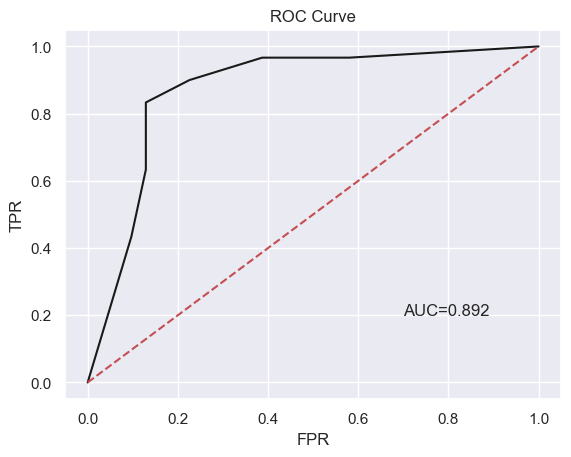

In [78]:
#ypp = knn.predict_proba(Xs_test)
ypp_knn = KnnClas.predict_proba(Xs_test[best_features])
#y_pred = knn.predict(Xs_test)
y_pred = KnnClas.predict(Xs_test[best_features])
fpr_knn, tpr_knn, th = roc_curve(y_test,ypp_knn[:,1])
auc_knn = roc_auc_score(y_test,ypp_knn[:,1])
plt.plot(fpr_knn,tpr_knn,'k-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'r--')
plt.title('ROC Curve');
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.text(0.7,0.2,'AUC='+"{:.3f}".format(auc));
######################
print("Logistic Regression Summary:\n", classification_report(y_test, y_pred))
#############
pruneresdict["KNN"]["auc"] = "{:.2f}".format(auc_knn)
pruneresdict["KNN"]["recall"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"])
pruneresdict["KNN"]["F1"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"])
#############

### Random Forest 
Modelling the input features against the target feature using a Random Forest approach. A gridsearch is used in order to optimize the Random Forest's tuning parameters: n-estimators, max depth, min sample split, min samples leaf, and max features. The gridsearch uses a 5 fold cross-validation. The Random Forest does not require normalized inputs, so the raw inputs are used in this model.

In [79]:
params = {
    'n_estimators': [100,200,300,400,500],
    'max_depth' : [None,10,30,50],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2],
    'max_features':['sqrt','log2']}
gridsearch = GridSearchCV(RandomForestClassifier(),params,cv=5,scoring='accuracy',n_jobs=-1)
gridsearch.fit(X_train,y_train)
print(gridsearch.best_params_)

{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [80]:
max_depth = gridsearch.best_params_['max_depth']
max_features = gridsearch.best_params_['max_features']
min_samples_leaf = gridsearch.best_params_['min_samples_leaf']
min_samples_split = gridsearch.best_params_['min_samples_split']
n_estimators = gridsearch.best_params_['n_estimators']
RF = RandomForestClassifier(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf,min_samples_split = min_samples_split,max_depth=max_depth)
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)
print(classification_report(y_test,y_pred))
best_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy with all inputs used")
print(f'Best Accuracy Attained: {best_accuracy:0.03f}')
###########
allresdict["RF"]["acc"] ="{:.2f}".format(best_accuracy)
###########
#############
ypp_rf = RF.predict_proba(X_test)
y_pred = RF.predict(X_test)
fpr_rf, tpr_rf, th = roc_curve(y_test,ypp_rf[:,1])
auc_rf = roc_auc_score(y_test,ypp_rf[:,1])
allresdict["RF"]["auc"] = "{:.2f}".format(auc_rf)
allresdict["RF"]["recall"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"])
allresdict["RF"]["F1"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"])
#############

              precision    recall  f1-score   support

           0       0.82      0.87      0.84        31
           1       0.86      0.80      0.83        30

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

Accuracy with all inputs used
Best Accuracy Attained: 0.836


### Pruning Input Features *(Random Forest)*
The scikit-learn Random Forest model includes a "feature_importances_" function that shows the relative importance of each input feature. I sorted these from least to most important and then step-wise removed each feature and re-fit the model until the accuracy lowered significantly. The input features sex, fbs, restecg, slope, exang, and trestbps could be dropped and the accuracy is reduced by about ~0.02. Dropping input features more important than these previously mentioned caused a more significant drop in accuracy and thus should be kept in the model.

Pruning in this manner eventually produces a model with an accuracy of 0.82 using 7 features.

In [81]:
importances=RF.feature_importances_
feature_names = list(X_train)
importance_dict = {}
for i in range(len(feature_names)):
    importance_dict[feature_names[i]] = float(importances[i])
#print(importance_dict)
sorted_items = sorted(importance_dict.items(), key=lambda item: item[1])
print("Feature Importance")
print(sorted_items)

Feature Importance
[('fbs', 0.0072240282630627), ('restecg', 0.012681960234648808), ('sex', 0.0270341018004044), ('slope', 0.05751709215575568), ('trestbps', 0.059824531151119346), ('chol', 0.062222981295781896), ('exang', 0.07255538638426455), ('age', 0.08823549268734374), ('oldpeak', 0.10438192084132543), ('thalach', 0.10971612787254811), ('thal', 0.12285864774400337), ('cp', 0.12776493080654144), ('ca', 0.14798279876320045)]


In [82]:
X_RF_train = X_train.drop(['sex','fbs','restecg','slope','exang','trestbps'], axis=1)
X_RF_test = X_test.drop(['sex','fbs','restecg','slope','exang','trestbps'], axis=1)

In [83]:
RF = RandomForestClassifier(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf,min_samples_split = min_samples_split,max_depth=max_depth)
RF.fit(X_RF_train,y_train)
y_pred = RF.predict(X_RF_test)
print(classification_report(y_test,y_pred))
###########
pruneresdict["RF"]["acc"] ="{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["accuracy"])
#print(X_RF_train.columns)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        31
           1       0.81      0.83      0.82        30

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



### Conclusion *(Random Forest)*
The target feature can be adequately predicted with chol, thal, sex, cp, exang, slope, and ca. The accuracy of the model after pruning is nearly equal to the model before pruning.

**AUC & ROC:** The ROC Curve and AUC is shown below. This model has an AUC of 0.874 which is very strong predictive preformance.

**Summary**: The classification report for the KNN is shown below. Note the accuracy of 0.82. The precision, recall, and F1-scores for correctly categorizing heart disease (0/1) is also in the low 0.80's, which is decent.

Logistic Regression Summary:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82        31
           1       0.81      0.83      0.82        30

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



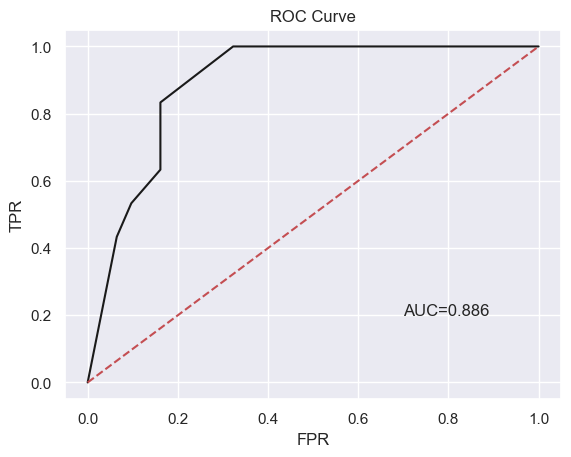

In [84]:
ypp_rf = RF.predict_proba(X_RF_test)
y_pred = RF.predict(X_RF_test)
fpr_rf, tpr_rf, th = roc_curve(y_test,ypp_rf[:,1])
auc_rf = roc_auc_score(y_test,ypp_rf[:,1])
plt.plot(fpr,tpr,'k-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'r--')
plt.title('ROC Curve');
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.text(0.7,0.2,'AUC='+"{:.3f}".format(auc_rf));
######################
print("Logistic Regression Summary:\n", classification_report(y_test, y_pred))
#############
pruneresdict["RF"]["auc"] = "{:.2f}".format(auc_rf)
pruneresdict["RF"]["recall"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"])
pruneresdict["RF"]["F1"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"])
#############

### SVM
Modelling the input features against the target feature using a support vector machine (SVM) approach. A gridsearch is used in order to optimize the SVM's tuning parameters: regularization parameter C, kernel type (linear,rbf,poly), and gamma. The gridsearch uses a 5 fold cross-validation. Normalized inputs are used in the SVM.

In [85]:
params = {
    'C': [0.1, 1, 5, 10, 30, 50, 80, 100, 150],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']}

grid = GridSearchCV(SVC(), params, cv=5, refit=True)
grid.fit(Xs_train, y_train)
#print(grid.best_params_)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 5, 10, 30, 50, 80, 100, 150],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']})

In [86]:
C = grid.best_params_['C']
gamma = grid.best_params_['gamma']
kernel = grid.best_params_['kernel']

In [87]:
SVCP = SVC(C=C,gamma=gamma,kernel=kernel,probability=True)
SVCP.fit(Xs_train,y_train)
y_pred = grid.predict(Xs_test)
acc = accuracy_score(y_test,y_pred)
report = classification_report(y_test,y_pred)
print(f'Accuracy is {acc:.03f}')
print(report)
###############
allresdict["SVM"]["acc"] ="{:.2f}".format(acc)
###############
ypp_svm = SVCP.predict_proba(Xs_test)
auc_svm = roc_auc_score(y_test,ypp_svm[:,1])
allresdict["SVM"]["auc"] = "{:.2f}".format(auc_svm)
allresdict["SVM"]["recall"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"])
allresdict["SVM"]["F1"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"])

Accuracy is 0.836
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        31
           1       0.83      0.83      0.83        30

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



### Pruning Input Features *(SVM)*
The common features that were removed from previous models are also removed from this one as an initial starting point. Then, each feature left is removed step-wise and noted if the accuracy changed significantly. Through this method, features sex, slope, and exang were also removed. With SVM, the model can predict the target feature with an accuracy of 0.87 using four features: chol, thal, cp, and ca.

In [88]:
X_SVM_Prune_train = Xs_train.drop(['age','trestbps','thalach','oldpeak','fbs','restecg','sex','exang','slope'], axis=1)
X_SVM_Prune_test = Xs_test.drop(['age','trestbps','thalach','oldpeak','fbs','restecg','sex','exang','slope'], axis=1)
params = {
    'C': [0.1, 1, 5, 10, 30, 50, 80, 100, 150],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']}

grid = GridSearchCV(SVC(), params, cv=5, refit=True)
grid.fit(X_SVM_Prune_train, y_train)
C = grid.best_params_['C']
gamma = grid.best_params_['gamma']
kernel = grid.best_params_['kernel']
SVCP = SVC(C=C,gamma=gamma,kernel=kernel,probability=True)
SVCP.fit(X_SVM_Prune_train,y_train)
y_pred = grid.predict(X_SVM_Prune_test)
acc = accuracy_score(y_test,y_pred)
report = classification_report(y_test,y_pred)
print(f'Accuracy is {acc:.03f}')
print(report)
#print(X_SVM_Prune_test.columns)
pruneresdict["SVM"]["acc"] ="{:.2f}".format(acc)
#############
ypp_svm = SVCP.predict_proba(X_SVM_Prune_test)
auc_svm = roc_auc_score(y_test,ypp_svm[:,1])
pruneresdict["SVM"]["auc"] = "{:.2f}".format(auc_svm)
pruneresdict["SVM"]["recall"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"])
pruneresdict["SVM"]["F1"] = "{:.2f}".format(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"])
#############

Accuracy is 0.869
              precision    recall  f1-score   support

           0       0.93      0.81      0.86        31
           1       0.82      0.93      0.88        30

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



### Conclusion *(SVM)*
The target feature can be adequately predicted with chol, thal, cp, and ca. The accuracy of the model after pruning is higher than before pruning.

**AUC & ROC:** The ROC Curve and AUC is shown below. This model has an AUC of 0.883 which is very strong predictive preformance.

**Summary**: The classification report for the KNN is shown below. Note the accuracy of 0.87. The precision, recall, and F1-scores for correctly categorizing heart disease (0/1) is also in the mid 0.80's, which is decent. This accuracy is attained using 4 of the input features.

Logistic Regression Summary:
               precision    recall  f1-score   support

           0       0.93      0.81      0.86        31
           1       0.82      0.93      0.88        30

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



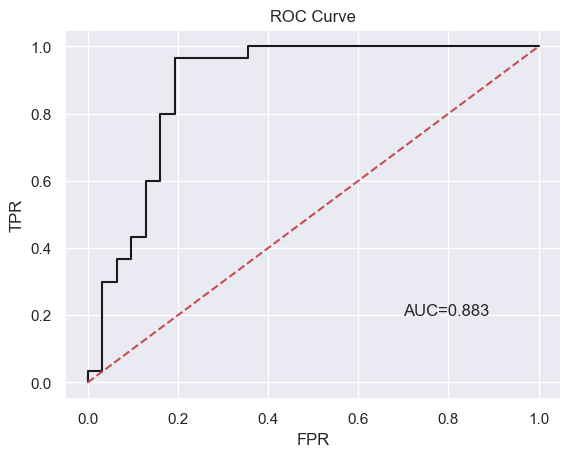

In [89]:
ypp_svm = SVCP.predict_proba(X_SVM_Prune_test)
y_pred = grid.predict(X_SVM_Prune_test)
fpr_svm, tpr_svm, th = roc_curve(y_test,ypp_svm[:,1])
auc_svm = roc_auc_score(y_test,ypp_svm[:,1])
plt.plot(fpr_svm,tpr_svm,'k-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'r--')
plt.title('ROC Curve');
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.text(0.7,0.2,'AUC='+"{:.3f}".format(auc_svm));
######################
print("Logistic Regression Summary:\n", classification_report(y_test, y_pred))
######################

### Summarized Results ###

Each of the different models developed had the choice of their hyperparameters optimized. This was done with a 5 cross-fold validation gridsearch with different values. The final result for each parameter choses are shown below for each model type.

**Logistic Regression Hyperparameters**: C = 0.01, class weight = None, penalty = l2, solver = saga

**Ridge Classifier Hyperparameters**: alpha = 100.0, solver = lsqr

**KNN Hyperparameters**: k-neighbors = 7

**Random Forest Hyperparameters**: max_depth = None, max_features = log2, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 200

**SVM Hyperparameters**: C = 0.1, gamma = scale, kernel = rbf


A summary of the results for each of the models is shown below. The metrics used for comparison are accuracy, F1-score (a blend of precision and recall), AUC, recall, and then the number of input features used to develop the model. These metrics are shown for each model developed with all of the input features used and then after pruning input features.



Model Algo,Acc,F1,AUC,Recall,n-features
Logistic Regression,0.85,0.85,0.89,0.83,13
Ridge Classifier,0.87,0.87,-,0.90,13
KNN,0.84,0.83,0.89,0.83,13
Random Forest,0.84,0.83,0.88,0.80,13
SVM,0.84,0.83,0.89,0.83,13


Model Algo,Acc,F1,AUC,Recall,n-features
Logistic Regression,0.85,0.85,0.88,0.87,7
Ridge Classifier,0.87,0.87,-,0.90,7
KNN,0.85,0.85,0.87,0.83,7
Random Forest,0.82,0.82,0.89,0.83,7
SVM,0.87,0.88,0.88,0.93,4


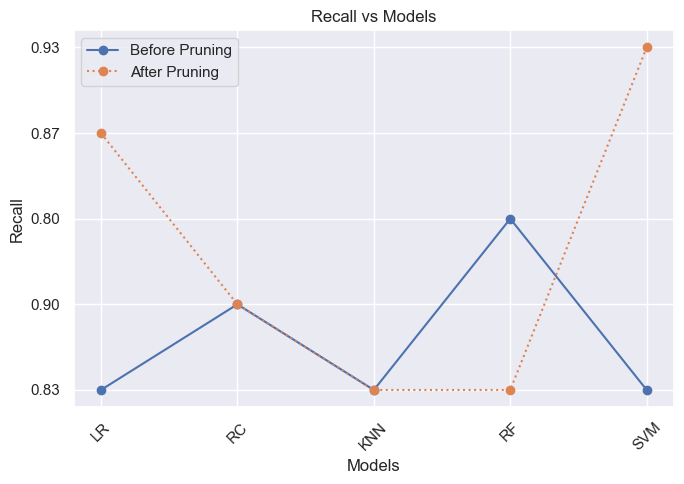

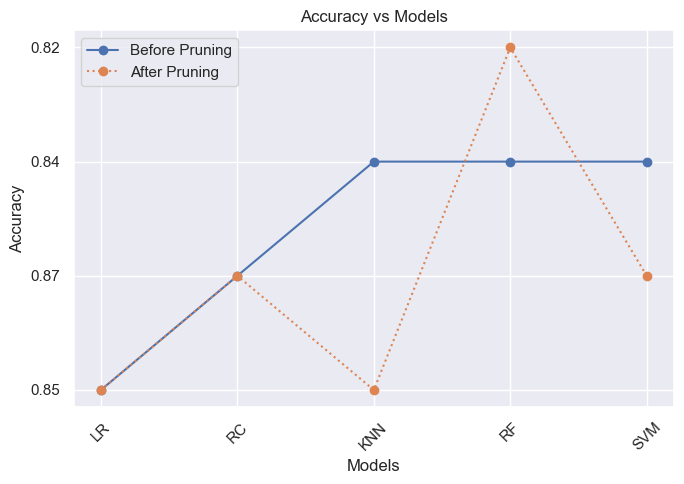

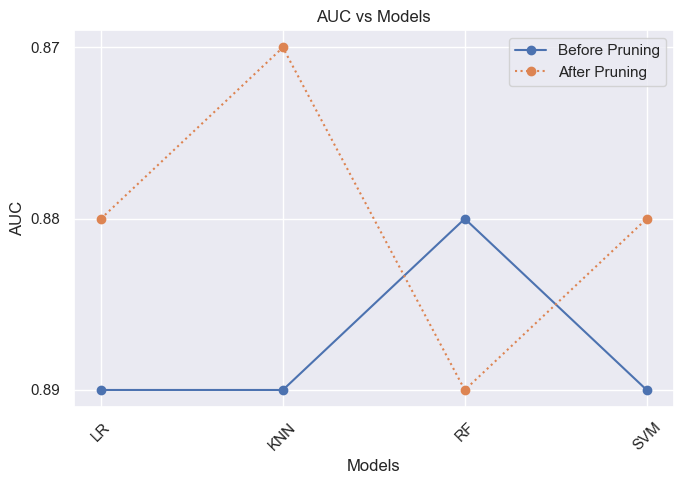

In [90]:
table = PrettyTable()
table.title = "Model Metrics Using All Input Features"
table.field_names = ["Model Algo","Acc","F1","AUC","Recall","n-features"]
table.add_row(["Logistic Regression",allresdict["LR"]["acc"],allresdict["LR"]["F1"],allresdict["LR"]["auc"],allresdict["LR"]["recall"],13])
table.add_row(["Ridge Classifier",allresdict["RC"]["acc"],allresdict["RC"]["F1"],"-",allresdict["RC"]["recall"],13])
table.add_row(["KNN",allresdict["KNN"]["acc"],allresdict["KNN"]["F1"],allresdict["KNN"]["auc"],allresdict["KNN"]["recall"],13])
table.add_row(["Random Forest",allresdict["RF"]["acc"],allresdict["RF"]["F1"],allresdict["RF"]["auc"],allresdict["RF"]["recall"],13])
table.add_row(["SVM",allresdict["SVM"]["acc"],allresdict["SVM"]["F1"],allresdict["SVM"]["auc"],allresdict["SVM"]["recall"],13])
display(table)
print("")
table = PrettyTable()
table.title = "Model Metrics After Pruning Features"
table.field_names = ["Model Algo","Acc","F1","AUC","Recall","n-features"]
table.add_row(["Logistic Regression",pruneresdict["LR"]["acc"],pruneresdict["LR"]["F1"],pruneresdict["LR"]["auc"],pruneresdict["LR"]["recall"],7])
table.add_row(["Ridge Classifier",pruneresdict["RC"]["acc"],pruneresdict["RC"]["F1"],"-",pruneresdict["RC"]["recall"],7])
table.add_row(["KNN",pruneresdict["KNN"]["acc"],pruneresdict["KNN"]["F1"],pruneresdict["KNN"]["auc"],pruneresdict["KNN"]["recall"],7])
table.add_row(["Random Forest",pruneresdict["RF"]["acc"],pruneresdict["RF"]["F1"],pruneresdict["RF"]["auc"],pruneresdict["RF"]["recall"],7])
table.add_row(["SVM",pruneresdict["SVM"]["acc"],pruneresdict["SVM"]["F1"],pruneresdict["SVM"]["auc"],pruneresdict["SVM"]["recall"],4])
display(table)

models = ['LR','RC','KNN','RF','SVM']
recall_before = [allresdict["LR"]["recall"],allresdict["RC"]["recall"],allresdict["KNN"]["recall"],allresdict["RF"]["recall"],allresdict["SVM"]["recall"]]
recall_after = [pruneresdict["LR"]["recall"],pruneresdict["RC"]["recall"],pruneresdict["KNN"]["recall"],pruneresdict["RF"]["recall"],pruneresdict["SVM"]["recall"]]
x_positions = range(len(models))
plt.figure(figsize=(7,5))
plt.plot(x_positions,recall_before,marker='o',linestyle='-',label='Before Pruning')
plt.plot(x_positions,recall_after,marker='o',linestyle='dotted',label='After Pruning')
plt.xticks(x_positions,models,rotation=45)
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall vs Models')
plt.legend()
plt.tight_layout()
plt.show()

models = ['LR','RC','KNN','RF','SVM']
acc_before = [allresdict["LR"]["acc"],allresdict["RC"]["acc"],allresdict["KNN"]["acc"],allresdict["RF"]["acc"],allresdict["SVM"]["acc"]]
acc_after = [pruneresdict["LR"]["acc"],pruneresdict["RC"]["acc"],pruneresdict["KNN"]["acc"],pruneresdict["RF"]["acc"],pruneresdict["SVM"]["acc"]]
x_positions = range(len(models))
plt.figure(figsize=(7,5))
plt.plot(x_positions,acc_before,marker='o',linestyle='-',label='Before Pruning')
plt.plot(x_positions,acc_after,marker='o',linestyle='dotted',label='After Pruning')
plt.xticks(x_positions,models,rotation=45)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Models')
plt.legend()
plt.tight_layout()
plt.show()

models = ['LR','KNN','RF','SVM']
auc_before = [allresdict["LR"]["auc"],allresdict["KNN"]["auc"],allresdict["RF"]["auc"],allresdict["SVM"]["auc"]]
auc_after = [pruneresdict["LR"]["auc"],pruneresdict["KNN"]["auc"],pruneresdict["RF"]["auc"],pruneresdict["SVM"]["auc"]]
x_positions = range(len(models))
plt.figure(figsize=(7,5))
plt.plot(x_positions,auc_before,marker='o',linestyle='-',label='Before Pruning')
plt.plot(x_positions,auc_after,marker='o',linestyle='dotted',label='After Pruning')
plt.xticks(x_positions,models,rotation=45)
plt.xlabel('Models')
plt.ylabel('AUC')
plt.title('AUC vs Models')
plt.legend()
plt.tight_layout()
plt.show()

The ROC curves for each of the models (except for the ridge classifier) is shown below. The models are all fairly similar.

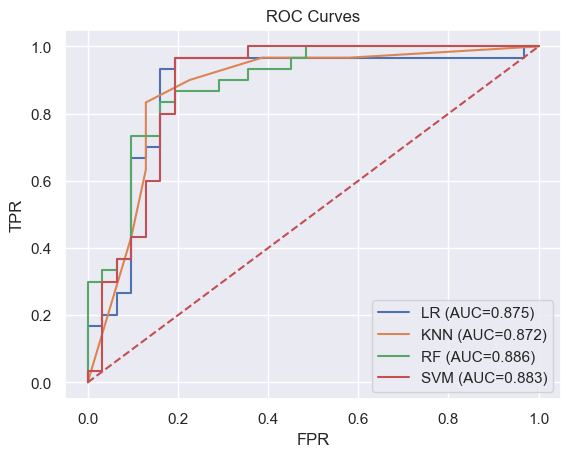

In [91]:
plt.plot(fpr_lr,tpr_lr,label='LR (AUC={:.3f})'.format(auc_lr))
plt.plot(fpr_knn,tpr_knn,label='KNN (AUC={:.3f})'.format(auc_knn))
plt.plot(fpr_rf,tpr_rf,label='RF (AUC={:.3f})'.format(auc_rf))
plt.plot(fpr_svm,tpr_svm, label='SVM (AUC={:.3f})'.format(auc_svm))
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'r--')
plt.title('ROC Curves');
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.legend(loc='lower right')

The features left after pruning each model are shown below. After pruning each of the models, a few of the input features that remained were common: **chol** (cholesterol), **thal** (thallium heart scan results), **cp** (chest pain type), **ca** (number of major blood vessels colored by fluoroscopy). These are clearly key features necessary to predict the presence of heart disease.

|LR|RC|KNN|RF|SVM|
|-|-|-|-|-|
|chol|chol|thalach|chol|chol|
|thal|thal|oldpeak|oldpeak|thal|
|sex|sex|thal|thal|cp|
|cp|cp|cp|cp|ca|
|exang|exang|restecg|age|
|slope|slope|exang|thalach|
|ca|ca|ca|ca|

### Discussion & Conclusions



Each of the different models performed equally-well, for the most part. The best model developed is the SVM model. It generated an accuracy of 0.87 with only 4 input features. KNN is also a very well performing model that is easy to interpret. There were some key learnings found while modelling. The logistic regression model is very quick to calculate and is even fast when optimizing its hyperparameters. This would be a useful model for very large datasets. Ridge classifier is very similar to logistic regression in being a lightweight model but also incorporates L2 regularization which reduces overfitting and provides robustness against multicollinearity among features. The KNN method is also lightweight and does not require hyperparameter tuning (besides the k-neighbor parameter), but even tuning the k-neighbor parameter is fast. The Random Forest method performed well, is capable of modelling non-linear relationships, robust against noise and overfitting, and works well with large datasets and high-dimensional data. The downside of the random forest model is that it is comparatively slow, especially when optimizing the hyperparameters. Finally, there is the SVM method which is effective in high-dimensional spaces, can model non-linear relationships, and is quick to optimize the hyperparameters.

I would recommend the SVM model due to it's simplicity (four input features) and high accuracy. It has high interpretability and simplicity and delivers robust performance using only a few key features.

#### Limitations

For some of the models, I attempted a greedy backward feature elimination method where I remove a feature, check by how much the accuracy changes, and then decide whether to permanently drop that feature or keep it based on a tolerance (usually 0.01). If the accuracy only dropped by 0.01 or so, then it is not adding a lot of value to the model and can be dropped. A simple model with a few input features and a decent accuracy value is often the preferred model to use in real-world applications over a model that has an artificially high accuracy value but includes many input features that are not significant and may be overfitted. As an example, the Logistic Regression includes the p-values for each of the inputs and that was a good starting point to remove any features whose p-values were > 0.05. After this, removing additional features one-by-one and checking the accuracy change resulted in more features being removed (even though their p-values were significant, these were not contributing a lot to the accuracy). This method does not guarantee an optimum input feature set, though. Doing this procedure manually sometimes produced surprising results - removing a feature sometimes *increased* the accuracy! Due to interactions of input features the best approach would be to optimize over every set of possible input feature combinations for a given size of input features to use instead of performing a greedy elimination strategy.

#### Future Improvements

Related to the above discussion, possible improvements for a future project is to further optimize the accuracy vs the amount of input features by attempting every combination of input features for **x**-amount of input features and then gradually increase the **x**-value until the accuracy does not increase significantly. For many of the methods, this is computationally expensive and it would not make sense to do it for each method. To get the best possible performing method with the least amount of input features used this is necessary.

Additionally, the dataset only has ~300 entries for 13 features (+1 target feature). Due to the amount of features versus the number of entries, there is a risk that overfitting occurred for many of the models. Doing a 5 fold cross-validation during the hyperparameter optimization helps to mitigate this, but more data is the best solution to overfitting concerns. For a future project, more data versus features will be used. Adding to this, validating the model against data from other sources would be beneficial to reduce any bias since the dataset used is sourced from one location.
